In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v1 import Autoencoder
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v2 import AR_AERNN_ESN as AR_AERNN
from tools.trainAEESN_ensemble import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-22 16:02:16.428644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-22 16:02:16.429814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 16:02:16.490106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 16:02:16.490365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 16:02:16.490562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 16:02:16.490750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN_ensemble/ESN_ensemble_000'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AEESN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_ESN_ensemble_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/0_final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ESN_ensemble/ESN_ensemble_000
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

In [14]:
print('all_data.shape : ', all_data.shape)
print('all_data.dtype : ', all_data.dtype)

all_data.shape :  (500026, 64)
all_data.dtype :  float64


# Autoencoder

In [15]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [16]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [17]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        # 5,
        10,
        30,
        50,
        70,
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [18]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-4, 5e-5, 1e-5],
        [1e-5, 5e-6, 1e-6],
        [1e-6, 5e-7, 1e-7],
        [1e-6, 5e-7, 1e-7],
    ]
    epochs = [
        [200]*3,
        [200]*3,
        [200]*3,
        [200]*3,
    ]
    patience = [
        [10]*3,#[25],
        [10]*3,#[30],
        [10]*3,#[35],
        [10]*3,#[40],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 7e-9  # weight for regularizer
    covmat_lmda = 8e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [19]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [20]:
def find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='weights.hdf5',
        classdict_matcher='class_dict.txt',
    ):
    contents_load_dir = [f for f in os.listdir(load_dir) if os.path.isfile(os.path.join(load_dir, f))]
    load_files_lst = [f for f in contents_load_dir if f.endswith(classdict_matcher)]
    wt_files_lst = [f for f in contents_load_dir if f.endswith(wt_matcher)]

    load_files_lst_startingidx = []
    for i in range(len(load_files_lst)):
        fn = load_files_lst[i]
        idx = fn.find('_')
        load_files_lst_startingidx.append(int(fn[0:idx]))

    wt_files_lst_startingidx = []
    for i in range(len(wt_files_lst)):
        fn = wt_files_lst[i]
        idx = fn.find('_')
        wt_files_lst_startingidx.append(int(fn[0:idx]))

    load_files_sortidx = np.argsort(load_files_lst_startingidx)
    wt_files_sortidx = np.argsort(wt_files_lst_startingidx)

    load_files_lst = np.array(load_files_lst)[load_files_sortidx]
    wt_files_lst = np.array(wt_files_lst)[wt_files_sortidx]

    load_file_rnn = [load_dir + '/' + fn for fn in load_files_lst]
    wt_file_rnn = [load_dir + '/' +  fn for fn in wt_files_lst]
    
    return load_file_rnn, wt_file_rnn

In [21]:
load_dir = dir_name_rnn + '/final_net'
load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(load_dir)



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0169 - mse: 0.0021 - NMSE: 0.0192 - NMSE_wt: 0.0168 - covmat_fro_loss: 0.0072 - global_gradnorm: 4.1676 - tot_time: 0h 1m 47.6s

Epoch 1: val_NMSE improved from inf to 0.00984, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR

Epoch 11/200
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 9.4463e-04 - NMSE: 0.0085 - NMSE_wt: 0.0074 - covmat_fro_loss: 0.0051 - global_gradnorm: 2.4450 - tot_time: 0h 7m 3.1s

Epoch 11: val_NMSE improved from 0.00894 to 0.00784, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 447ms/step - loss: 0.0075 - mse: 9.4463e-04 - NMSE: 0.0085 - NMSE_wt: 0.0074 - covmat_fro_loss: 0.0051 - global_gradnorm: 2.4515 - val_loss: 0.0070 - val_mse: 8.7123e-04 - val_NMSE: 0.0078 - val_NMSE_wt: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 9.1351e-04 - NMSE: 0.0082 - NMSE_wt: 0.0

Epoch 22/200
71/71 [==============================] - ETA: 0s - loss: 0.0067 - mse: 8.3690e-04 - NMSE: 0.0075 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.9034 - tot_time: 0h 12m 50.9s

Epoch 22: val_NMSE did not improve from 0.00784
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 448ms/step - loss: 0.0067 - mse: 8.3690e-04 - NMSE: 0.0075 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.8978 - val_loss: 0.0071 - val_mse: 8.8544e-04 - val_NMSE: 0.0080 - val_NMSE_wt: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/200
71/71 [==============================] - ETA: 0s - loss: 0.0069 - mse: 8.6814e-04 - NMSE: 0.0078 - NMSE_wt: 0.0068 - covmat_fro_loss: 0.0049 - global_gradnorm: 1.9914 - tot_time: 0h 13m 22.8s

Epoch 23: val_NMSE did not improve from 0.00784
 - savin

Epoch 33/200
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 8.9806e-04 - NMSE: 0.0081 - NMSE_wt: 0.0070 - covmat_fro_loss: 0.0050 - global_gradnorm: 1.9095 - tot_time: 0h 18m 40.2s

Epoch 33: val_NMSE did not improve from 0.00712
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 451ms/step - loss: 0.0072 - mse: 8.9806e-04 - NMSE: 0.0081 - NMSE_wt: 0.0070 - covmat_fro_loss: 0.0050 - global_gradnorm: 1.9054 - val_loss: 0.0074 - val_mse: 9.2523e-04 - val_NMSE: 0.0083 - val_NMSE_wt: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/200
71/71 [==============================] - ETA: 0s - loss: 0.0068 - mse: 8.4576e-04 - NMSE: 0.0076 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.7620 - tot_time: 0h 19m 11.7s

Epoch 34: val_NMSE did not improve from 0.00712
 - savin

71/71 [==============================] - ETA: 0s - loss: 0.0066 - mse: 8.2129e-04 - NMSE: 0.0074 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.7848 - tot_time: 0h 24m 29.8s

Epoch 44: val_NMSE did not improve from 0.00712
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 447ms/step - loss: 0.0066 - mse: 8.2129e-04 - NMSE: 0.0074 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.7901 - val_loss: 0.0085 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_NMSE_wt: 0.0084 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 45/200
71/71 [==============================] - ETA: 0s - loss: 0.0067 - mse: 8.4127e-04 - NMSE: 0.0076 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.7618 - tot_time: 0h 25m 1.6s

Epoch 45: val_NMSE did not improve from 0.00712
 - saving loss histories a

Epoch 55/200
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 8.0874e-04 - NMSE: 0.0073 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0047 - global_gradnorm: 1.5556 - tot_time: 0h 30m 18.7s

Epoch 55: val_NMSE improved from 0.00688 to 0.00667, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 450ms/step - loss: 0.0065 - mse: 8.0874e-04 - NMSE: 0.0073 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0048 - global_gradnorm: 1.5511 - val_loss: 0.0060 - val_mse: 7.4164e-04 - val_NMSE: 0.0067 - val_NMSE_wt: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 56/200
71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 7.2757e-04 - NMSE: 0.0065 - NMSE_wt: 0

Epoch 66/200
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.5033e-04 - NMSE: 0.0068 - NMSE_wt: 0.0059 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.4017 - tot_time: 0h 36m 6.9s

Epoch 66: val_NMSE did not improve from 0.00594
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 447ms/step - loss: 0.0060 - mse: 7.5033e-04 - NMSE: 0.0068 - NMSE_wt: 0.0059 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.4014 - val_loss: 0.0071 - val_mse: 8.9361e-04 - val_NMSE: 0.0080 - val_NMSE_wt: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 67/200
71/71 [==============================] - ETA: 0s - loss: 0.0068 - mse: 8.4789e-04 - NMSE: 0.0076 - NMSE_wt: 0.0067 - covmat_fro_loss: 0.0049 - global_gradnorm: 1.4464 - tot_time: 0h 36m 38.3s

Epoch 67: val_NMSE did not improve from 0.00594
 - saving

71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.4515e-04 - NMSE: 0.0067 - NMSE_wt: 0.0059 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.2871 - tot_time: 0h 41m 54.7s

Epoch 77: val_NMSE did not improve from 0.00594
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 450ms/step - loss: 0.0060 - mse: 7.4515e-04 - NMSE: 0.0067 - NMSE_wt: 0.0059 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.2867 - val_loss: 0.0059 - val_mse: 7.3356e-04 - val_NMSE: 0.0066 - val_NMSE_wt: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 78/200
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 7.0918e-04 - NMSE: 0.0064 - NMSE_wt: 0.0056 - covmat_fro_loss: 0.0045 - global_gradnorm: 1.3264 - tot_time: 0h 42m 26.1s

Epoch 78: val_NMSE did not improve from 0.00594
 - saving loss histor

Epoch 88/200
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.4281e-04 - NMSE: 0.0067 - NMSE_wt: 0.0058 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.1689 - tot_time: 0h 47m 42.7s

Epoch 88: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 446ms/step - loss: 0.0060 - mse: 7.4281e-04 - NMSE: 0.0067 - NMSE_wt: 0.0058 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.1710 - val_loss: 0.0055 - val_mse: 6.8875e-04 - val_NMSE: 0.0062 - val_NMSE_wt: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 89/200
71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 6.9194e-04 - NMSE: 0.0062 - NMSE_wt: 0.0054 - covmat_fro_loss: 0.0044 - global_gradnorm: 1.1377 - tot_time: 0h 48m 14.5s

Epoch 89: val_NMSE did not improve from 0.00521
 - savin

71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 7.2643e-04 - NMSE: 0.0065 - NMSE_wt: 0.0057 - covmat_fro_loss: 0.0045 - global_gradnorm: 1.1842 - tot_time: 0h 53m 30.9s

Epoch 99: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 446ms/step - loss: 0.0058 - mse: 7.2643e-04 - NMSE: 0.0065 - NMSE_wt: 0.0057 - covmat_fro_loss: 0.0045 - global_gradnorm: 1.1907 - val_loss: 0.0072 - val_mse: 9.0096e-04 - val_NMSE: 0.0081 - val_NMSE_wt: 0.0071 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 100/200
71/71 [==============================] - ETA: 0s - loss: 0.0061 - mse: 7.6478e-04 - NMSE: 0.0069 - NMSE_wt: 0.0060 - covmat_fro_loss: 0.0046 - global_gradnorm: 1.2853 - tot_time: 0h 54m 2.7s

Epoch 100: val_NMSE did not improve from 0.00521
 - saving loss histo

71/71 [==============================] - ETA: 0s - loss: 0.0063 - mse: 7.8946e-04 - NMSE: 0.0071 - NMSE_wt: 0.0062 - covmat_fro_loss: 0.0047 - global_gradnorm: 1.2534 - tot_time: 0h 59m 19.3s

Epoch 110: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 31s 442ms/step - loss: 0.0063 - mse: 7.8946e-04 - NMSE: 0.0071 - NMSE_wt: 0.0062 - covmat_fro_loss: 0.0047 - global_gradnorm: 1.2545 - val_loss: 0.0055 - val_mse: 6.8625e-04 - val_NMSE: 0.0062 - val_NMSE_wt: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 111/200
71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 6.9016e-04 - NMSE: 0.0062 - NMSE_wt: 0.0054 - covmat_fro_loss: 0.0044 - global_gradnorm: 1.0480Restoring model weights from the end of the best epoch: 86.
 - tot_time: 0h 59m 50.6s

Epoch 1

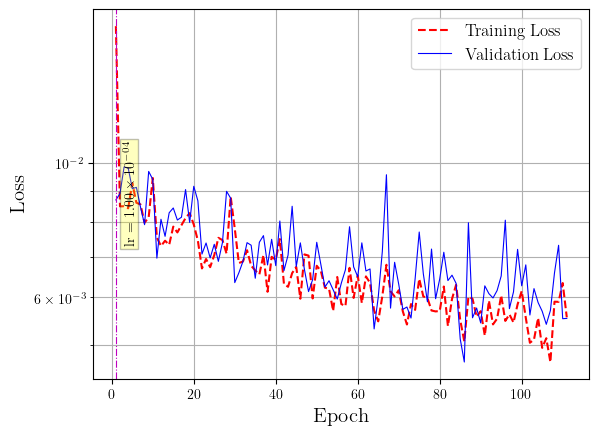

<Figure size 640x480 with 0 Axes>

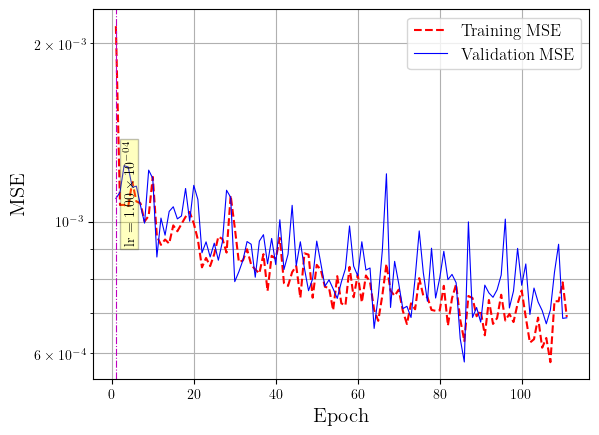

<Figure size 640x480 with 0 Axes>

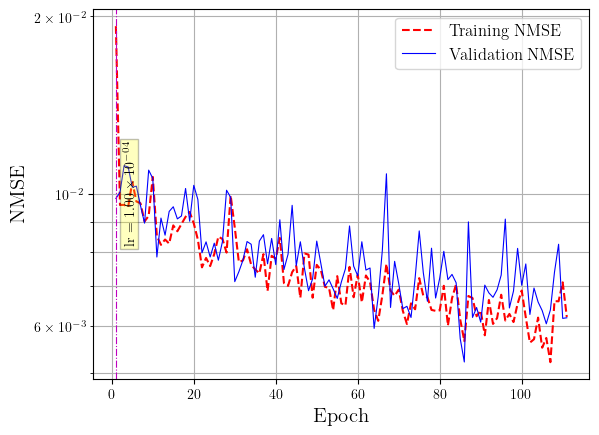

<Figure size 640x480 with 0 Axes>

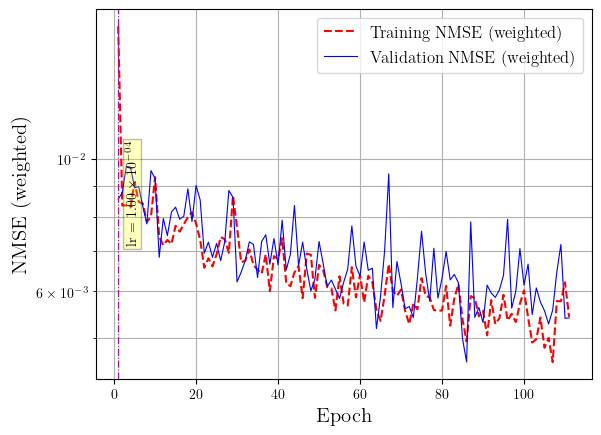

<Figure size 640x480 with 0 Axes>

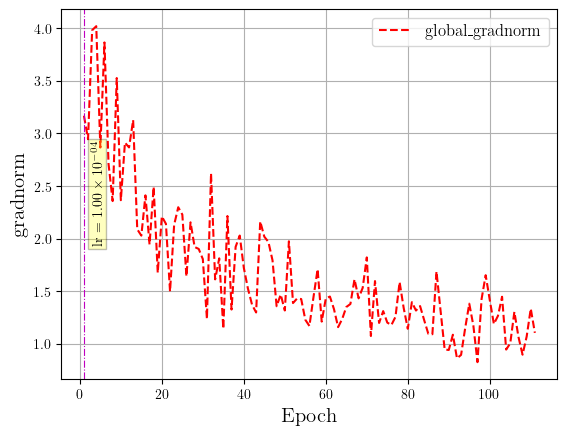



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 4.0


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
58/58 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0034 - NMSE: 0.0303 - NMSE_wt: 0.0195 - covmat_fro_loss: 0.0177 - global_gradnorm: 2.1477 - tot_time: 0h 4m 35.9s

Epoch 1: val_NMSE improved from inf to 0.02824, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_

Epoch 11/200
58/58 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0028 - NMSE: 0.0248 - NMSE_wt: 0.0159 - covmat_fro_loss: 0.0160 - global_gradnorm: 2.1171 - tot_time: 0h 12m 5.6s

Epoch 11: val_NMSE did not improve from 0.02537
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 775ms/step - loss: 0.0161 - mse: 0.0028 - NMSE: 0.0248 - NMSE_wt: 0.0159 - covmat_fro_loss: 0.0160 - global_gradnorm: 2.1218 - val_loss: 0.0171 - val_mse: 0.0029 - val_NMSE: 0.0264 - val_NMSE_wt: 0.0170 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
58/58 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0028 - NMSE: 0.0248 - NMSE_wt: 0.0160 - covmat_fro_loss: 0.0160 - global_gradnorm: 2.1947 - tot_time: 0h 12m 50.7s

Epoch 12: val_NMSE did not improve from 0.02537
 - saving loss histories 

58/58 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0027 - NMSE: 0.0243 - NMSE_wt: 0.0156 - covmat_fro_loss: 0.0159 - global_gradnorm: 2.1582 - tot_time: 0h 20m 19.7s

Epoch 22: val_NMSE did not improve from 0.02443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 775ms/step - loss: 0.0158 - mse: 0.0027 - NMSE: 0.0243 - NMSE_wt: 0.0156 - covmat_fro_loss: 0.0159 - global_gradnorm: 2.1563 - val_loss: 0.0164 - val_mse: 0.0028 - val_NMSE: 0.0252 - val_NMSE_wt: 0.0162 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/200
58/58 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0028 - NMSE: 0.0248 - NMSE_wt: 0.0160 - covmat_fro_loss: 0.0160 - global_gradnorm: 2.2011 - tot_time: 0h 21m 4.8s

Epoch 23: val_NMSE did not improve from 0.02443
 - saving loss histories at /home/rkau

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 778ms/step - loss: 0.0156 - mse: 0.0027 - NMSE: 0.0241 - NMSE_wt: 0.0155 - covmat_fro_loss: 0.0159 - global_gradnorm: 2.2028 - val_loss: 0.0166 - val_mse: 0.0028 - val_NMSE: 0.0255 - val_NMSE_wt: 0.0165 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/200
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0026 - NMSE: 0.0234 - NMSE_wt: 0.0151 - covmat_fro_loss: 0.0155 - global_gradnorm: 1.9966 - tot_time: 0h 29m 19.0s

Epoch 34: val_NMSE did not improve from 0.02443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 780ms/step - loss: 0.0152 - mse: 0.0026 - NMSE: 0.0234 - NMSE_wt: 0.0

Epoch 45/200
58/58 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0027 - NMSE: 0.0246 - NMSE_wt: 0.0158 - covmat_fro_loss: 0.0161 - global_gradnorm: 2.2688 - tot_time: 0h 37m 32.9s

Epoch 45: val_NMSE did not improve from 0.02443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 774ms/step - loss: 0.0160 - mse: 0.0027 - NMSE: 0.0246 - NMSE_wt: 0.0158 - covmat_fro_loss: 0.0160 - global_gradnorm: 2.2791 - val_loss: 0.0169 - val_mse: 0.0029 - val_NMSE: 0.0260 - val_NMSE_wt: 0.0167 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 46/200
58/58 [==============================] - ETA: 0s - loss: 0.0168 - mse: 0.0029 - NMSE: 0.0259 - NMSE_wt: 0.0167 - covmat_fro_loss: 0.0165 - global_gradnorm: 2.4921 - tot_time: 0h 38m 17.9s

Epoch 46: val_NMSE improved from 0.02443 to 0.02434, saving model to /ho

Epoch 56/200
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 0.0025 - NMSE: 0.0226 - NMSE_wt: 0.0145 - covmat_fro_loss: 0.0153 - global_gradnorm: 2.0529 - tot_time: 0h 45m 48.1s

Epoch 56: val_NMSE did not improve from 0.02360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 779ms/step - loss: 0.0147 - mse: 0.0025 - NMSE: 0.0226 - NMSE_wt: 0.0145 - covmat_fro_loss: 0.0153 - global_gradnorm: 2.0520 - val_loss: 0.0158 - val_mse: 0.0027 - val_NMSE: 0.0244 - val_NMSE_wt: 0.0157 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 57/200
58/58 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0025 - NMSE: 0.0228 - NMSE_wt: 0.0147 - covmat_fro_loss: 0.0153 - global_gradnorm: 1.9620 - tot_time: 0h 46m 33.3s

Epoch 57: val_NMSE did not improve from 0.02360
 - saving loss histories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 775ms/step - loss: 0.0155 - mse: 0.0027 - NMSE: 0.0239 - NMSE_wt: 0.0154 - covmat_fro_loss: 0.0157 - global_gradnorm: 2.2501 - val_loss: 0.0165 - val_mse: 0.0028 - val_NMSE: 0.0255 - val_NMSE_wt: 0.0164 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 68/200
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0026 - NMSE: 0.0236 - NMSE_wt: 0.0152 - covmat_fro_loss: 0.0157 - global_gradnorm: 2.1727 - tot_time: 0h 54m 48.9s

Epoch 68: val_NMSE did not improve from 0.02360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_004/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 45s 778ms/step - loss: 0.0153 - mse: 0.0026 - NMSE: 0.0236 - NMSE_wt: 0.0

In [ ]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    
    load_dir = dir_name_ARrnn+'/final_net/{}_outsteps'.format(num_outsteps)
    load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='ESN_weights.hdf5',
        classdict_matcher='ESN_class_dict.txt'
    )
    
    load_file_ae = load_dir + '/final_net-{}_outsteps_ae_class_dict.txt'.format(num_outsteps)
    wt_file_ae = load_dir + '/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(load_dir+'/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)

In [ ]:
### Training the combined AE-RNN


# 